# Table of Contents

- [Data Preprocessing](##Data-Preprocessing)
  - [Taxi Data](####Taxi-Data-Preprocessing)
  - [Restaurant Data](####Restaurant-Data-Preprocessing)
- [Linking Datasets](##Linking-2-datasets-spatially)
- [Map Visualization](##Exploarotry-Map-Vizualization)
- [Exploratory Data Analysis](##Exploratory-Data-Analysis)
  - [Relation among Travel, Borough and Meal Time](####a%29-Understanding-relation-among-Travel,-Borough-and-Meal-Time)
  - [Relation among Average Tip, Cuisine, Borough, Meal Time and Number of Passengers](####b%29-Understanding-relation-among-Average-Tip,-Cuisine,-Borough,-Meal-Time-and-Number-of-Passengers)
- [Model Setup /Data](##Model-Setup-/-Data)



## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import seaborn as sns
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import json

## Datasets

In [2]:
taxi_df = pd.read_csv("NYC_taxi.csv")
restaurant_df = pd.read_csv("DOHMH_New_York_City_Restaurant_Inspection_Results.csv", dtype={"BUILDING": str, "STREET": str, "ZIPCODE": str})

In [3]:
taxi_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42 +00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00 +00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00 +00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18 +00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36 +00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30
...,...,...,...,...,...,...,...,...,...,...,...,...
97981,1,2015-01-15 06:04:36 +00:00,2015-01-15 06:09:13 +00:00,1,1.00,-73.973167,40.744244,-73.975433,40.752487,5.5,1.26,7.56
97982,1,2015-01-15 06:04:36 +00:00,2015-01-15 06:43:36 +00:00,1,16.70,-73.965134,40.759991,-73.782372,40.644108,52.0,13.20,66.00
97983,1,2015-01-15 06:04:36 +00:00,2015-01-15 06:17:32 +00:00,1,4.50,-74.015182,40.715755,-73.981285,40.765930,15.5,1.00,17.30
97984,1,2015-01-15 06:04:37 +00:00,2015-01-15 06:09:38 +00:00,1,0.80,-73.971794,40.754051,-73.982391,40.759842,5.5,1.00,7.30


In [4]:
restaurant_df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016,2126863400,Italian,11/25/2014,Violations were cited in the following area(s).,20F,Current letter grade card not posted.,Not Critical,NaN,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106,3478134702,Italian,10/03/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314,7189839854,Chinese,05/17/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,46.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209,7187019180,American,03/30/2017,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,18.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399913,41004284,CAFE CLASSICO,MANHATTAN,35,WEST 57 STREET,10019,2123555411,Jewish/Kosher,01/28/2016,Violations were cited in the following area(s).,04C,Food worker does not use proper utensil to eli...,Critical,19.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
399914,40368318,MAGGIES PLACE,MANHATTAN,21,EAST 47 STREET,10017,2127535757,American,02/29/2016,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,11.0,A,02/29/2016,08/28/2017,Cycle Inspection / Re-inspection
399915,50051468,Yong Kong Street,MANHATTAN,1000S,8TH AVE,10019,9176406083,Japanese,01/05/2017,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,25.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
399916,41555297,RUBY FALLS NIGHTLIFE CAFE,STATEN ISLAND,45,PAGE AVENUE,10309,7189849888,American,09/19/2014,Violations were cited in the following area(s).,10I,"Single service item reused, improperly stored,...",Not Critical,12.0,A,09/19/2014,08/28/2017,Cycle Inspection / Re-inspection


## Data Preprocessing

#### Taxi Data Preprocessing

In [5]:
# Checking for Null Values
print(taxi_df.isna().sum())

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
fare_amount              0
tip_amount               0
total_amount             0
dtype: int64


In [6]:
# Eliminating rows where the passenger count is zero 
print(taxi_df["passenger_count"].unique())
taxi_df = taxi_df.drop(taxi_df[taxi_df["passenger_count"]==0].index)

# Converting dropoff attribute to datetime object 
taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'])


[1 5 2 6 3 4 0]


In [7]:
# Selecting rides between lunchtime (11:30am -2pm) and dinnertime (5pm - 9pm)

drop_time = taxi_df['tpep_dropoff_datetime'].dt.time
lunch_start = pd.to_datetime('11:30:00').time()
lunch_end = pd.to_datetime('14:00:00').time()
dinner_start = pd.to_datetime('17:00:00').time()
dinner_end = pd.to_datetime('21:00:00').time()

mask = ((drop_time >= lunch_start) & (drop_time <= lunch_end)) | ((drop_time >= dinner_start) & (drop_time <= dinner_end))
taxi_filtered = taxi_df[mask]
taxi_filtered

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:23:42+00:00,1,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,3.25,17.05
1,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00+00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,4.38,22.68
2,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:21:00+00:00,5,2.83,-73.968704,40.754246,-73.955124,40.786858,12.5,0.00,14.30
3,2,2015-01-15 19:05:40 +00:00,2015-01-15 19:28:18+00:00,5,8.33,-73.863060,40.769581,-73.952713,40.785782,26.0,8.08,41.21
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:20:36+00:00,1,2.37,-73.945541,40.779423,-73.980850,40.786083,11.5,0.00,13.30
...,...,...,...,...,...,...,...,...,...,...,...,...
97972,2,2015-01-15 12:01:01 +00:00,2015-01-15 12:13:43+00:00,1,2.10,-73.988632,40.743530,-73.980568,40.722446,10.5,1.00,12.30
97973,2,2015-01-15 12:01:01 +00:00,2015-01-15 12:46:31+00:00,1,20.15,-73.950333,40.775810,-74.181480,40.687740,77.5,0.00,89.55
97974,2,2015-01-15 12:01:01 +00:00,2015-01-15 12:11:53+00:00,1,1.83,-73.959389,40.780121,-73.982399,40.775471,9.5,0.00,10.30
97975,2,2015-01-15 12:01:02 +00:00,2015-01-15 12:16:15+00:00,1,2.21,-74.005058,40.726089,-74.012962,40.712978,10.5,0.00,11.30


#### Restaurant Data Preprocessing

In [8]:
# Removing columns that are not relevant (Data regarding inspection results)

restaurant_df = restaurant_df.iloc[:,:8]
print(restaurant_df.isna().sum())

CAMIS                    0
DBA                    359
BORO                     0
BUILDING               109
STREET                   9
ZIPCODE                  9
PHONE                    5
CUISINE DESCRIPTION      0
dtype: int64


In [9]:
# Removing the longitudinal  nature of data (Keeping unique values of the restaurant)

restaurant_df = restaurant_df.drop_duplicates(subset='CAMIS')
restaurant_df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016,2126863400,Italian
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106,3478134702,Italian
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314,7189839854,Chinese
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209,7187019180,American
5,50015855,KABAB HOUSE NYC,QUEENS,4339,MAIN ST,11355,9172852796,Pakistani
...,...,...,...,...,...,...,...,...
399028,50064356,ROAST KITCHEN,MANHATTAN,209,W 57TH ST,10019,6469129920,Other
399279,50068112,CHILES GRILL,MANHATTAN,2131,3RD AVE,10035,3474479278,Other
399280,50069080,NaN,MANHATTAN,329,W 51ST ST,10019,9177762000,Other
399539,50060461,JIA XIANG KITCHEN INC,BROOKLYN,802,56TH ST,11220,7188533988,Other


In [10]:
# Shortening cuisine description for better graphics for charts

restaurant_df["CUISINE DESCRIPTION"] = restaurant_df["CUISINE DESCRIPTION"].replace({'CafÃ©/Coffee/Tea':'Cafe', 'Bottled beverages, including water, sodas, juices, etc.':'Bottled beverages',
'Latin (Cuban, Dominican, Puerto Rican, South & Central American)':'Latin'})


In [11]:
restaurant_df["CUISINE DESCRIPTION"].unique()

array(['Italian', 'Chinese', 'American', 'Pakistani', 'Japanese',
       'Caribbean', 'Seafood', 'Pizza', 'Indian', 'Soul Food', 'Mexican',
       'Latin', 'Bagels/Pretzels', 'Steak', 'Korean', 'Tapas',
       'Chinese/Japanese', 'Hamburgers', 'Vegetarian', 'Turkish',
       'African', 'Spanish', 'Cafe', 'Greek', 'Bakery', 'Continental',
       'Brazilian', 'Mediterranean', 'Salads', 'Thai', 'Asian',
       'Pizza/Italian', 'Donuts', 'Delicatessen', 'Jewish/Kosher',
       'Sandwiches', 'Russian', 'Vietnamese/Cambodian/Malaysia', 'Other',
       'Sandwiches/Salads/Mixed Buffet', 'Peruvian', 'Tex-Mex',
       'Bottled beverages', 'Irish', 'French', 'German',
       'Ice Cream, Gelato, Yogurt, Ices', 'Middle Eastern',
       'Juice, Smoothies, Fruit Salads', 'Chicken', 'Australian',
       'Bangladeshi', 'Creole', 'Hotdogs', 'Soups', 'Hotdogs/Pretzels',
       'English', 'Hawaiian', 'Pancakes/Waffles', 'Scandinavian',
       'Filipino', 'Californian', 'Polish', 'Barbecue', 'Afghan',
    

In [12]:
# Creating an ADDRESS attribute that combines information from building, street, and zipcode attributes
restaurant_df["ADDRESS"] = restaurant_df["BUILDING"]+" "+restaurant_df["STREET"]+", NEW YORK, NY, "+restaurant_df["ZIPCODE"]+", United States"
restaurant_df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ADDRESS
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016,2126863400,Italian,"635 SECOND AVENUE, NEW YORK, NY, 10016, United..."
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106,3478134702,Italian,"2507 BROADWAY, NEW YORK, NY, 11106, United States"
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314,7189839854,Chinese,"11C HOLDEN BLVD, NEW YORK, NY, 10314, United S..."
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209,7187019180,American,"8015 5 AVENUE, NEW YORK, NY, 11209, United States"
5,50015855,KABAB HOUSE NYC,QUEENS,4339,MAIN ST,11355,9172852796,Pakistani,"4339 MAIN ST, NEW YORK, NY, 11355, United States"
...,...,...,...,...,...,...,...,...,...
399028,50064356,ROAST KITCHEN,MANHATTAN,209,W 57TH ST,10019,6469129920,Other,"209 W 57TH ST, NEW YORK, NY, 10019, United States"
399279,50068112,CHILES GRILL,MANHATTAN,2131,3RD AVE,10035,3474479278,Other,"2131 3RD AVE, NEW YORK, NY, 10035, United States"
399280,50069080,NaN,MANHATTAN,329,W 51ST ST,10019,9177762000,Other,"329 W 51ST ST, NEW YORK, NY, 10019, United States"
399539,50060461,JIA XIANG KITCHEN INC,BROOKLYN,802,56TH ST,11220,7188533988,Other,"802 56TH ST, NEW YORK, NY, 11220, United States"


In [13]:
# Storing all the unique addresses  in a new dataframe to fetch its respective latitude and longitude 

unique_addres = pd.DataFrame({'Unique Adress': restaurant_df["ADDRESS"].unique()})

unique_addres

,Unique Adress
0,"635 SECOND AVENUE, NEW YORK, NY, 10016, United..."
1,"2507 BROADWAY, NEW YORK, NY, 11106, United States"
2,"11C HOLDEN BLVD, NEW YORK, NY, 10314, United S..."
3,"8015 5 AVENUE, NEW YORK, NY, 11209, United States"
4,"4339 MAIN ST, NEW YORK, NY, 11355, United States"
...,...
23950,"300 FURMAN ST, NEW YORK, NY, 11201, United States"
23951,"209 W 57TH ST, NEW YORK, NY, 10019, United States"
23952,"2131 3RD AVE, NEW YORK, NY, 10035, United States"
23953,"329 W 51ST ST, NEW YORK, NY, 10019, United States"


In [14]:
"""Using Bing Maps API to fetch latitude and longitude for restaurants"""

# from geopy.geocoders import Bing


# # Create a Bing geocoder instance and provide credentials
# geolocator = Bing(api_key='API_KEY')

# # Geocode the addresses and store the results in a new column
# unique_addres['Location'] = unique_addres['Unique Adress'].apply(geolocator.geocode)

# # Extract the latitude and longitude from the geocode results and store in separate columns
# unique_addres['Latitude'] = unique_addres['Location'].apply(lambda loc: loc.latitude if loc else None)
# unique_addres['Longitude'] = unique_addres['Location'].apply(lambda loc: loc.longitude if loc else None)

# Saving dataframe to csv file
# unique_addres.to_csv('GeocodedRes.csv', index=False)

'Using Bing Maps API to fetch latitude and longitude for restaurants'

In [15]:
# Fetching the latitude and longitude data of restaurants

restro_lat_long = pd.read_csv('GeocodedRes.csv')
restro_lat_long = restro_lat_long.rename(columns={'Unique Adress': 'ADDRESS'})
restro_lat_long.head()

,ADDRESS,Location,Latitude,Longitude
0,"635 SECOND AVENUE, NEW YORK, NY, 10016, United...","635 2nd Ave, New York, NY 10016, United States",40.745298,-73.975852
1,"2507 BROADWAY, NEW YORK, NY, 11106, United States","2507 Broadway, Queens, NY 11106, United States",40.763436,-73.927901
2,"11C HOLDEN BLVD, NEW YORK, NY, 10314, United S...","11 Holden Blvd, Staten Island, NY 10314, Unite...",40.604663,-74.121136
3,"8015 5 AVENUE, NEW YORK, NY, 11209, United States","8015 5th Ave, Brooklyn, NY 11209, United States",40.625288,-74.024181
4,"4339 MAIN ST, NEW YORK, NY, 11355, United States","4339 Main St, Queens, NY 11355, United States",40.751650,-73.825802


In [16]:
#Appending latitude and longitude values to the restaurant dataframe

restaurant_filtered = pd.merge(restaurant_df, restro_lat_long, on='ADDRESS', how='left')
restaurant_filtered

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ADDRESS,Location,Latitude,Longitude
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016,2126863400,Italian,"635 SECOND AVENUE, NEW YORK, NY, 10016, United...","635 2nd Ave, New York, NY 10016, United States",40.745298,-73.975852
1,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106,3478134702,Italian,"2507 BROADWAY, NEW YORK, NY, 11106, United States","2507 Broadway, Queens, NY 11106, United States",40.763436,-73.927901
2,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314,7189839854,Chinese,"11C HOLDEN BLVD, NEW YORK, NY, 10314, United S...","11 Holden Blvd, Staten Island, NY 10314, Unite...",40.604663,-74.121136
3,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209,7187019180,American,"8015 5 AVENUE, NEW YORK, NY, 11209, United States","8015 5th Ave, Brooklyn, NY 11209, United States",40.625288,-74.024181
4,50015855,KABAB HOUSE NYC,QUEENS,4339,MAIN ST,11355,9172852796,Pakistani,"4339 MAIN ST, NEW YORK, NY, 11355, United States","4339 Main St, Queens, NY 11355, United States",40.751650,-73.825802
...,...,...,...,...,...,...,...,...,...,...,...,...
26500,50064356,ROAST KITCHEN,MANHATTAN,209,W 57TH ST,10019,6469129920,Other,"209 W 57TH ST, NEW YORK, NY, 10019, United States","209 W 57th St, New York, NY 10019, United States",40.765925,-73.980419
26501,50068112,CHILES GRILL,MANHATTAN,2131,3RD AVE,10035,3474479278,Other,"2131 3RD AVE, NEW YORK, NY, 10035, United States","2131 3rd Ave, New York, NY 10035, United States",40.798196,-73.939594
26502,50069080,NaN,MANHATTAN,329,W 51ST ST,10019,9177762000,Other,"329 W 51ST ST, NEW YORK, NY, 10019, United States","329 W 51st St, New York, NY 10019, United States",40.763619,-73.986883
26503,50060461,JIA XIANG KITCHEN INC,BROOKLYN,802,56TH ST,11220,7188533988,Other,"802 56TH ST, NEW YORK, NY, 11220, United States","802 56th St, Brooklyn, NY 11220, United States",40.637617,-74.007047


## Linking 2 datasets spatially

In [17]:
restaurant_tree = cKDTree(restaurant_filtered[['Longitude', 'Latitude']])

matches = []
for i, row in taxi_filtered.iterrows():
    # Get the latitude and longitude of the taxi destination
    taxi_dest = np.array([row['dropoff_longitude'], row['dropoff_latitude']])
    
    # Find all the restaurants within a 50-meter radius of the taxi destination
    idxs = restaurant_tree.query_ball_point(taxi_dest, r=0.00044245)    # r value is in degree decimal
    
    # If there are any restaurants within the radius, select the closest one
    if len(idxs) > 0:
        dists = np.linalg.norm(restaurant_filtered.loc[idxs, ['Longitude', 'Latitude']].values - taxi_dest, axis=1)
        closest_restaurant_idx = idxs[np.argmin(dists)]
        
        # Append the match to the matches list
        matches.append((i, closest_restaurant_idx))

matched_taxi_df = pd.DataFrame(matches, columns=['taxi_index', 'restaurant_index'])


In [18]:
# Stores the indices of the taxi data that is matched with indices of restaurant data
matched_taxi_df

,taxi_index,restaurant_index
0,1,11870
1,6,18944
2,7,2392
3,8,14420
4,10,14456
...,...,...
20419,97967,20623
20420,97968,11211
20421,97969,4645
20422,97975,21278


In [19]:
# Combining the taxi data and restaurant data
temp_taxi_filter = taxi_filtered.loc[matched_taxi_df['taxi_index']].reset_index()
temp_restaurant_filter = restaurant_filtered.loc[matched_taxi_df['restaurant_index']].reset_index()

# Data shows which taxis stopped within 50m radius of the restaurant
matched_df = pd.concat([temp_taxi_filter,temp_restaurant_filter], axis=1)

In [20]:
# Removing attributes that are not relevant  
matched_df = matched_df.drop(['index','BUILDING', 'STREET','ZIPCODE', 'PHONE'], axis = 1).reset_index(drop=True)

In [21]:
# Adding a new attribute that indicates whether a ride was completed during Lunch or Dinner
matched_df['meal_time'] = matched_df['tpep_dropoff_datetime'].dt.hour.apply(lambda x: 'lunch' if x < 14 else 'dinner')

In [22]:
# Final Result
matched_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,...,total_amount,CAMIS,DBA,BORO,CUISINE DESCRIPTION,ADDRESS,Location,Latitude,Longitude,meal_time
0,2,2015-01-15 19:05:39 +00:00,2015-01-15 19:32:00+00:00,1,2.38,-73.976425,40.739811,-73.983978,40.757889,16.5,...,22.68,41596546,MARGON RESTAURANT,MANHATTAN,Latin,"136 WEST 46 STREET, NEW YORK, NY, 10036, Uni...","136 W 46th St, New York, NY 10036, United States",40.757865,-73.983976,dinner
1,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:31:00+00:00,1,3.60,-73.976601,40.751896,-73.998924,40.714596,17.5,...,19.30,40720599,PEKING DUCK HOUSE,MANHATTAN,Chinese,"28 MOTT STREET, NEW YORK, NY, 10013, United St...","28 Mott St, New York, NY 10013, United States",40.714596,-73.998726,dinner
2,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:10:22+00:00,1,0.89,-73.994957,40.745079,-73.999939,40.734650,5.5,...,8.92,50043664,QUALITY EATS,MANHATTAN,American,"19 GREENWICH AVE, NEW YORK, NY, 10014, United ...","19 Greenwich Ave, New York, NY 10014, United S...",40.734531,-74.000067,dinner
3,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:10:55+00:00,1,0.96,-74.000938,40.747063,-74.003563,40.735512,5.5,...,8.60,41021991,EXTRA VIRGIN,MANHATTAN,Mediterranean,"259 WEST 4 STREET, NEW YORK, NY, 10014, Uni...","259 W 4th St, New York, NY 10014, United States",40.735418,-74.003131,dinner
4,2,2015-01-15 19:05:41 +00:00,2015-01-15 19:22:11+00:00,5,2.11,-73.997459,40.736362,-73.978172,40.761856,11.5,...,15.80,41011016,STARBUCKS COFFEE,MANHATTAN,Cafe,"1320 AVENUE OF THE AMERICAS, NEW YORK, NY, 100...","1320 Avenue of the Americas, New York, NY 1001...",40.761926,-73.978465,dinner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20419,2,2015-01-15 12:01:00 +00:00,2015-01-15 12:06:30+00:00,1,0.69,-73.962036,40.773296,-73.968010,40.765388,5.5,...,7.40,50039094,VAUCLUSE,MANHATTAN,French,"575 PARK AVE, NEW YORK, NY, 10065, United States","575 Park Ave, New York, NY 10065, United States",40.765055,-73.967789,lunch
20420,2,2015-01-15 12:01:00 +00:00,2015-01-15 12:07:50+00:00,1,0.69,-73.972488,40.763031,-73.975388,40.754692,6.0,...,6.80,50001869,SOCIETE GENERALE CAFETERIA,MANHATTAN,American,"245 PARK AVE, NEW YORK, NY, 10167, United States","245 Park Ave, New York, NY 10017, United States",40.754848,-73.975258,lunch
20421,2,2015-01-15 12:01:00 +00:00,2015-01-15 12:12:32+00:00,5,1.33,-73.968979,40.751869,-73.977196,40.764767,9.0,...,11.60,50003545,THE WAYFARER,MANHATTAN,Seafood,"101 W 57TH ST, NEW YORK, NY, 10019, United States","101 W 57th St, New York, NY 10019, United States",40.764863,-73.977194,lunch
20422,2,2015-01-15 12:01:02 +00:00,2015-01-15 12:16:15+00:00,1,2.21,-74.005058,40.726089,-74.012962,40.712978,10.5,...,11.30,50008532,CONDE NAST,MANHATTAN,American,"1 WORLD TRADE CENTER, NEW YORK, NY, 10048, Uni...","1 World Trade Ctr, New York, NY 10007, United ...",40.713000,-74.013192,lunch


##  Exploratory Map Vizualization

In [23]:
print(matched_df["CUISINE DESCRIPTION"].unique())
print("Total Cuisine",len(matched_df["CUISINE DESCRIPTION"].unique()))

['Latin' 'Chinese' 'American' 'Mediterranean' 'Cafe' 'French' 'Other'
 'Sandwiches' 'Pizza' 'Juice, Smoothies, Fruit Salads' 'Hamburgers'
 'Chinese/Japanese' 'Bottled beverages' 'Pizza/Italian' 'Mexican'
 'Sandwiches/Salads/Mixed Buffet' 'Steak' 'Italian' 'Turkish' 'Irish'
 'Thai' 'Delicatessen' 'Japanese' 'Hotdogs' 'Jewish/Kosher' 'Soul Food'
 'Salads' 'Bakery' 'Vegetarian' 'Bagels/Pretzels' 'Tapas' 'Asian'
 'Barbecue' 'Chicken' 'Donuts' 'Seafood' 'Russian' 'Spanish' 'Indian'
 'Brazilian' 'Soups & Sandwiches' 'Eastern European'
 'Ice Cream, Gelato, Yogurt, Ices' 'Hotdogs/Pretzels' 'Peruvian' 'Tex-Mex'
 'Greek' 'Hawaiian' 'Middle Eastern' 'German' 'Moroccan' 'Bangladeshi'
 'Ethiopian' 'Vietnamese/Cambodian/Malaysia' 'Continental' 'Caribbean'
 'Chinese/Cuban' 'Korean' 'Iranian' 'Armenian' 'Californian'
 'Not Listed/Not Applicable' 'Pakistani' 'Chilean' 'African' 'Australian'
 'Portuguese' 'Polish' 'Nuts/Confectionary' 'Filipino' 'English'
 'Egyptian' 'Soups' 'Scandinavian' 'Southwestern

In [24]:
# We can see that some of the 78 distinct cuisines listed above are duplicated.
# Ex: 'Pizza/Italian' and 'Pizza'

# For better map visualization, we can group these cuisines into broader categories like Latin, Chinese, Asian, American, Mediterranean, European, Ethnic, and Other

latin = "Latin"
chinese = "Chinese"
asian ="Asian"
amr="American"
med = "Mediterranean"
eur = "European"
ethnic = "Ethnic"
other = "Other"
replace_cuisne = {"Mexican": latin, "Brazilian": latin, "Peruvian":latin, "Caribbean":latin, "Chilean":latin,
                  "Chinese":chinese, "Chinese/Jap;anese": chinese, "Chinese/Cuban":chinese, "Chinese/Japanese":chinese,
                  "Vietnamese/Cambodian/Malaysia": asian, "Korean": asian, "Thai": asian, "Japanese": asian, "Filipino":asian, "Indonesian":asian, "Asian":asian,
                  "Indian":asian, "Pakistani": asian, "Iranian":asian, "Bangladeshi":asian,
                  "American":amr,"Hamburgers":amr,"Hotdogs":amr,"Barbecue":amr, "Californian":amr, "Tex-Mex":amr,"Southwestern":amr,"Creole":amr,
                  "Steak":amr, "Hawaiian":amr, "Hotdogs/Pretzels":amr,
                  "Mediterranean":med, "Greek":med, "Turkish":med, "Spanish":med, "Portuguese":med, "Middle Eastern":med, "Moroccan":med, "Continental":med,
                  "French":eur, "Italian":eur, "Irish":eur, "German":eur, "Eastern European": eur, "Russian":eur, "Polish":eur, "English": eur, 
                  "Scandinavian":eur, "Armenian":eur, "Pizza":eur, "Pizza/Italian":eur, "Jewish/Kosher":eur,
                  "Ethiopian":ethnic, "African":ethnic, "Australian":ethnic,"Egyptian":ethnic, "Afghan":ethnic, "Seafood":ethnic,
                  "Cafe":other, "Other":other, "Sandwiches":other, "Juice, Smoothies, Fruit Salads":other, "Bottled beverages":other, 
                  "Salads":other, "Bakery":other,"Vegetarian":other, "Bagels/Pretzels":other, "Tapas":other, "Donuts":other, 
                  "Ice Cream, Gelato, Yogurt, Ices":other, "Nuts/Confectionary":other,"Soups":other, 'Soul Food':other, 
                  "Sandwiches/Salads/Mixed Buffet":other, "Not Listed/Not Applicable":other, "Soups & Sandwiches":other, "Delicatessen":other,
                  "Chicken":other} 

map_df = matched_df.copy()
map_df["CUISINE DESCRIPTION"] = map_df["CUISINE DESCRIPTION"].replace(replace_cuisne)

##### The map visualization below shows which kinds of cuisines people visited throughout lunch and dinner.
Legend For Cuisines   
![Legend For Cuisines](img/Icons.jpg "Title")  



Click play to watch animation   
![Map Animation](img/Icons2.jpg "Click play to watch animation")

In [25]:
# Loads the map using config data

f=open('config_cuisine.json')
config_data = json.load(f)

cuisine_map = KeplerGl(height=700, data ={"Cusine":map_df}, config=config_data)
cuisine_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Cusine'], 'id': 'q5je77kq',…

In [26]:
# Saving the exploratory map configuration in a json file

# config_file = cuisine_map.config

# with open("config_cuisine.json", "w") as outfile:
#     json.dump(config_file, outfile)

##### The map visualization below shows the heatmap for the number of people in the different boroughs during lunch and dinner.

In [27]:
# Loads the map using config data


f=open('config_passenger.json')
config_pax_data = json.load(f)

passenger_heatmap = KeplerGl(height=700, data ={"Passenger Heatmap":map_df}, config = config_pax_data)
passenger_heatmap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Passenger Heatmap'], 'id': …

In [28]:
# # Saving the exploratory map configuration in a json file

# config_passenger_file = passenger_heatmap.config

# with open("config_passenger.json", "w") as outfile:
#     json.dump(config_passenger_file, outfile)

##  Exploratory Data Analysis

#### a) Understanding relation among Travel, Borough and Meal Time

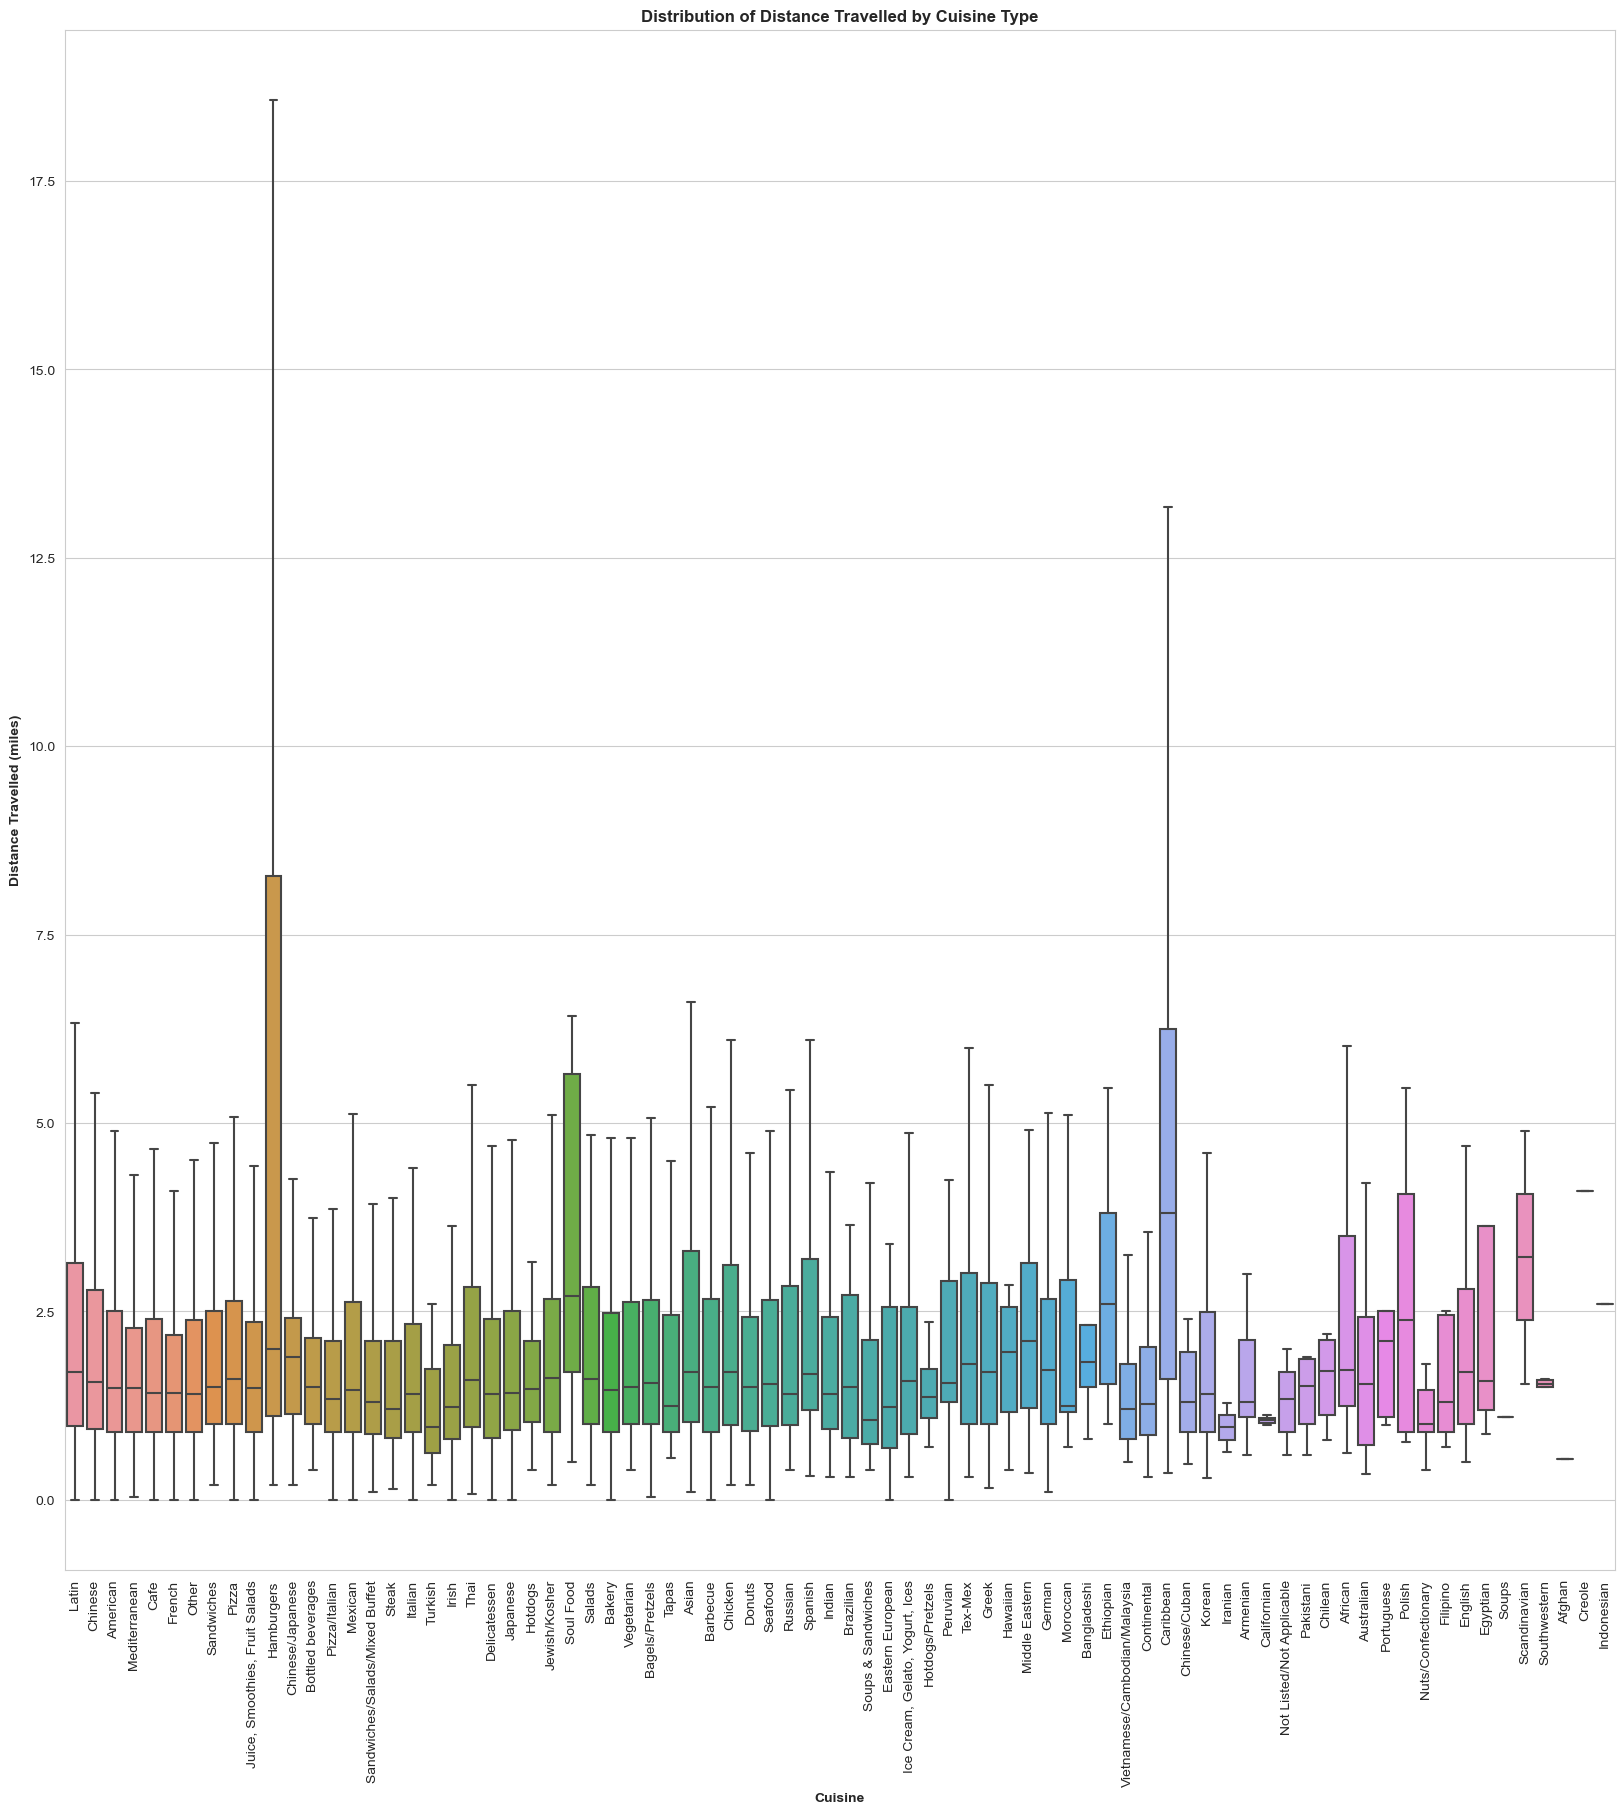

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,20))
sns.boxplot(x='CUISINE DESCRIPTION', y='trip_distance', data=matched_df, showfliers = False)
plt.xticks(rotation=90)
plt.xlabel('Cuisine',fontweight='bold')
plt.ylabel('Distance Travelled (miles)',fontweight='bold')
plt.title('Distribution of Distance Travelled by Cuisine Type', fontweight='bold')
plt.show()

In general, in New York City, we can notice that the median for the distance traveled for most cuisine are almost similar. Thus people prefer traveling less than 2.5 miles irrespective of the cuisine.

For the largest whisker plot, Hamburger Cuisine, we can notice that people have traveled a distance between 0.1-20 miles and have a high variance, but the average is still around 2 miles.

Some lower ends whiskers start at 0, indicating that people have taken very short rides(a few seconds) to get to the restaurants. 

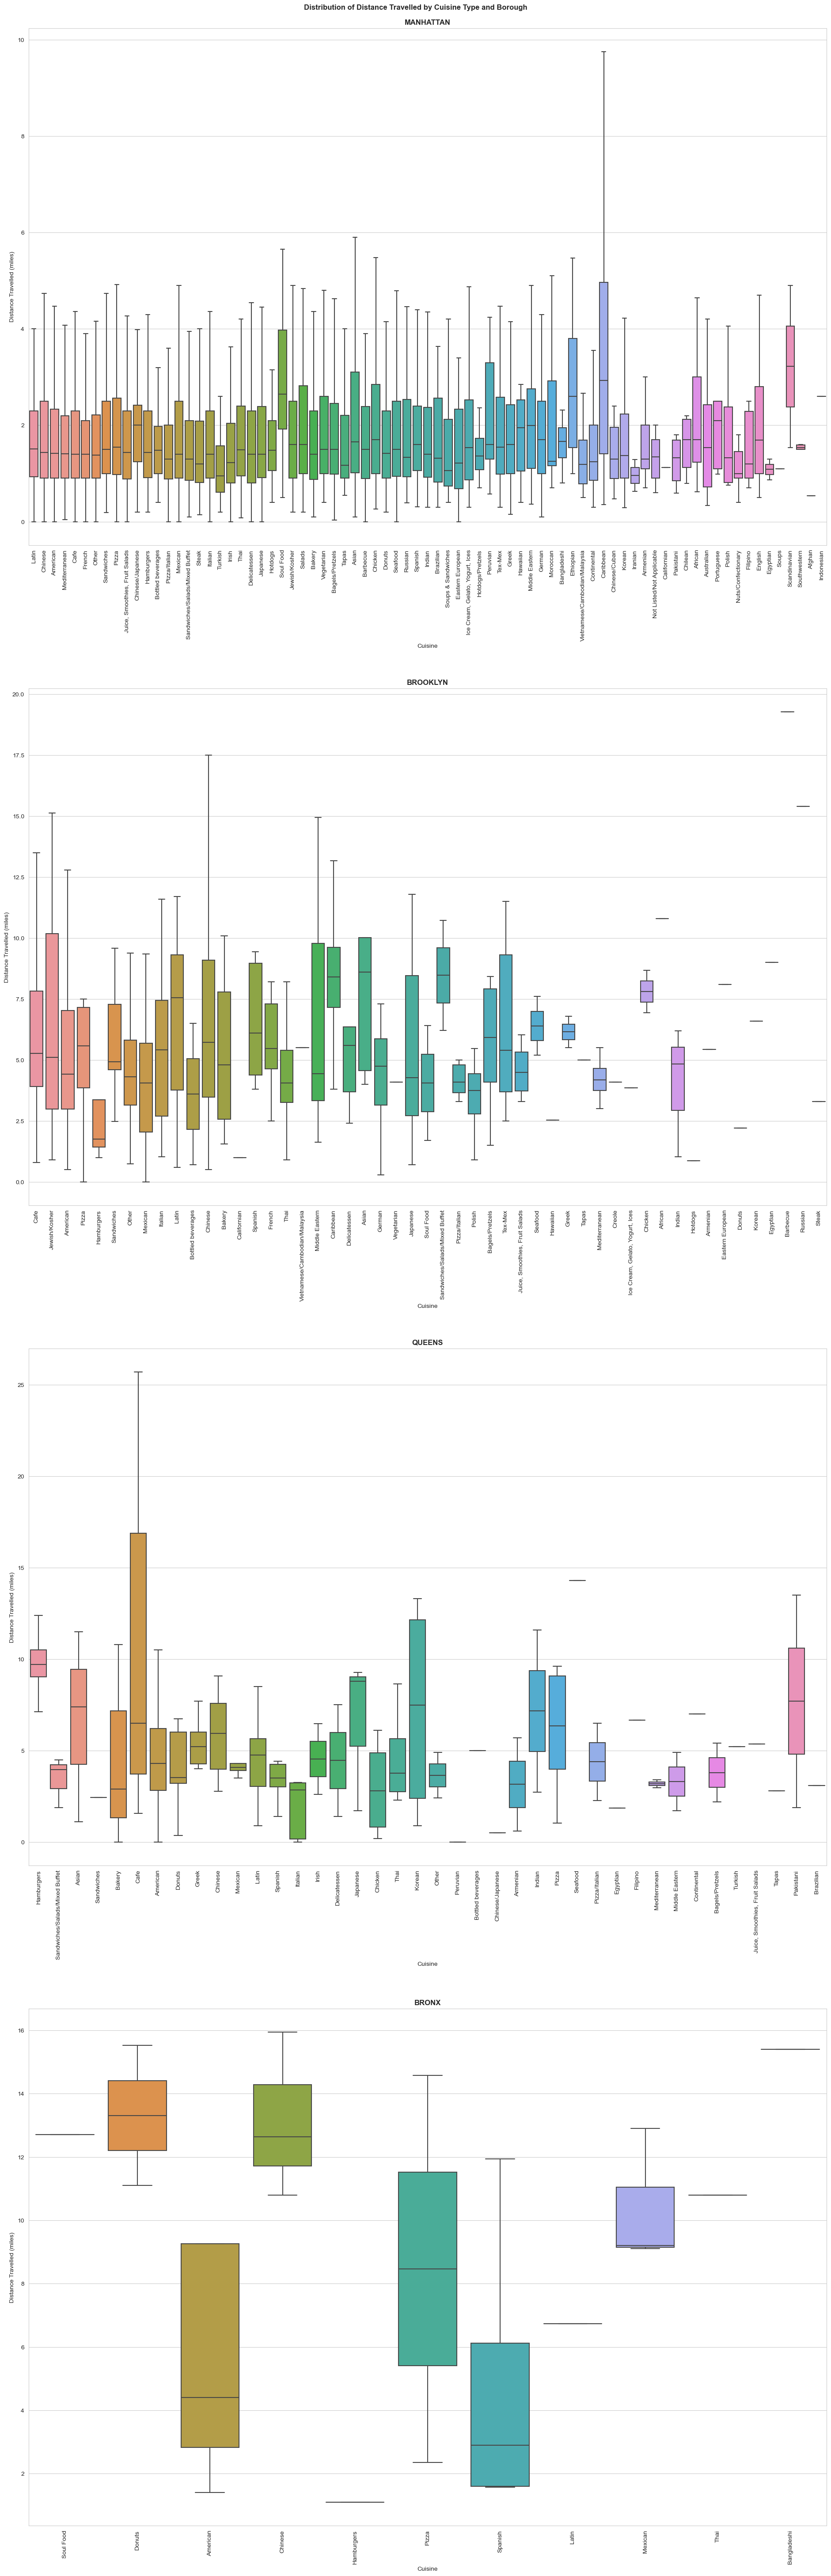

In [30]:
no_of_boro = len(matched_df['BORO'].unique())

sns.set_style("whitegrid")
fig, axs = plt.subplots(no_of_boro, 1, figsize=(20, 60))
for i, boro in enumerate(matched_df['BORO'].unique()):
    boro_data = matched_df[matched_df['BORO'] == boro]
    sns.boxplot(x='CUISINE DESCRIPTION', y='trip_distance', data=boro_data, ax=axs[i], showfliers = False)
    axs[i].set_title(boro, fontweight='bold')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_xlabel('Cuisine')
    axs[i].set_ylabel('Distance Travelled (miles)')
plt.suptitle('Distribution of Distance Travelled by Cuisine Type and Borough', fontweight='bold')
plt.tight_layout(pad=5.0)
plt.show()

Manhattan  
>On average, people have traveled more for Caribbean, Seafood, and Scandinavian cuisine than others.


Brooklyn  
>There is a lot of variation indicating that people have traveled long distances for cuisines on average compared to Manhattan.  
 

Queens   
>Similar inference can be made as Brooklyn but for fewer cuisines.


Bronx
>The sparsity of the data indicates that not many people visit the Bronx during meal time.



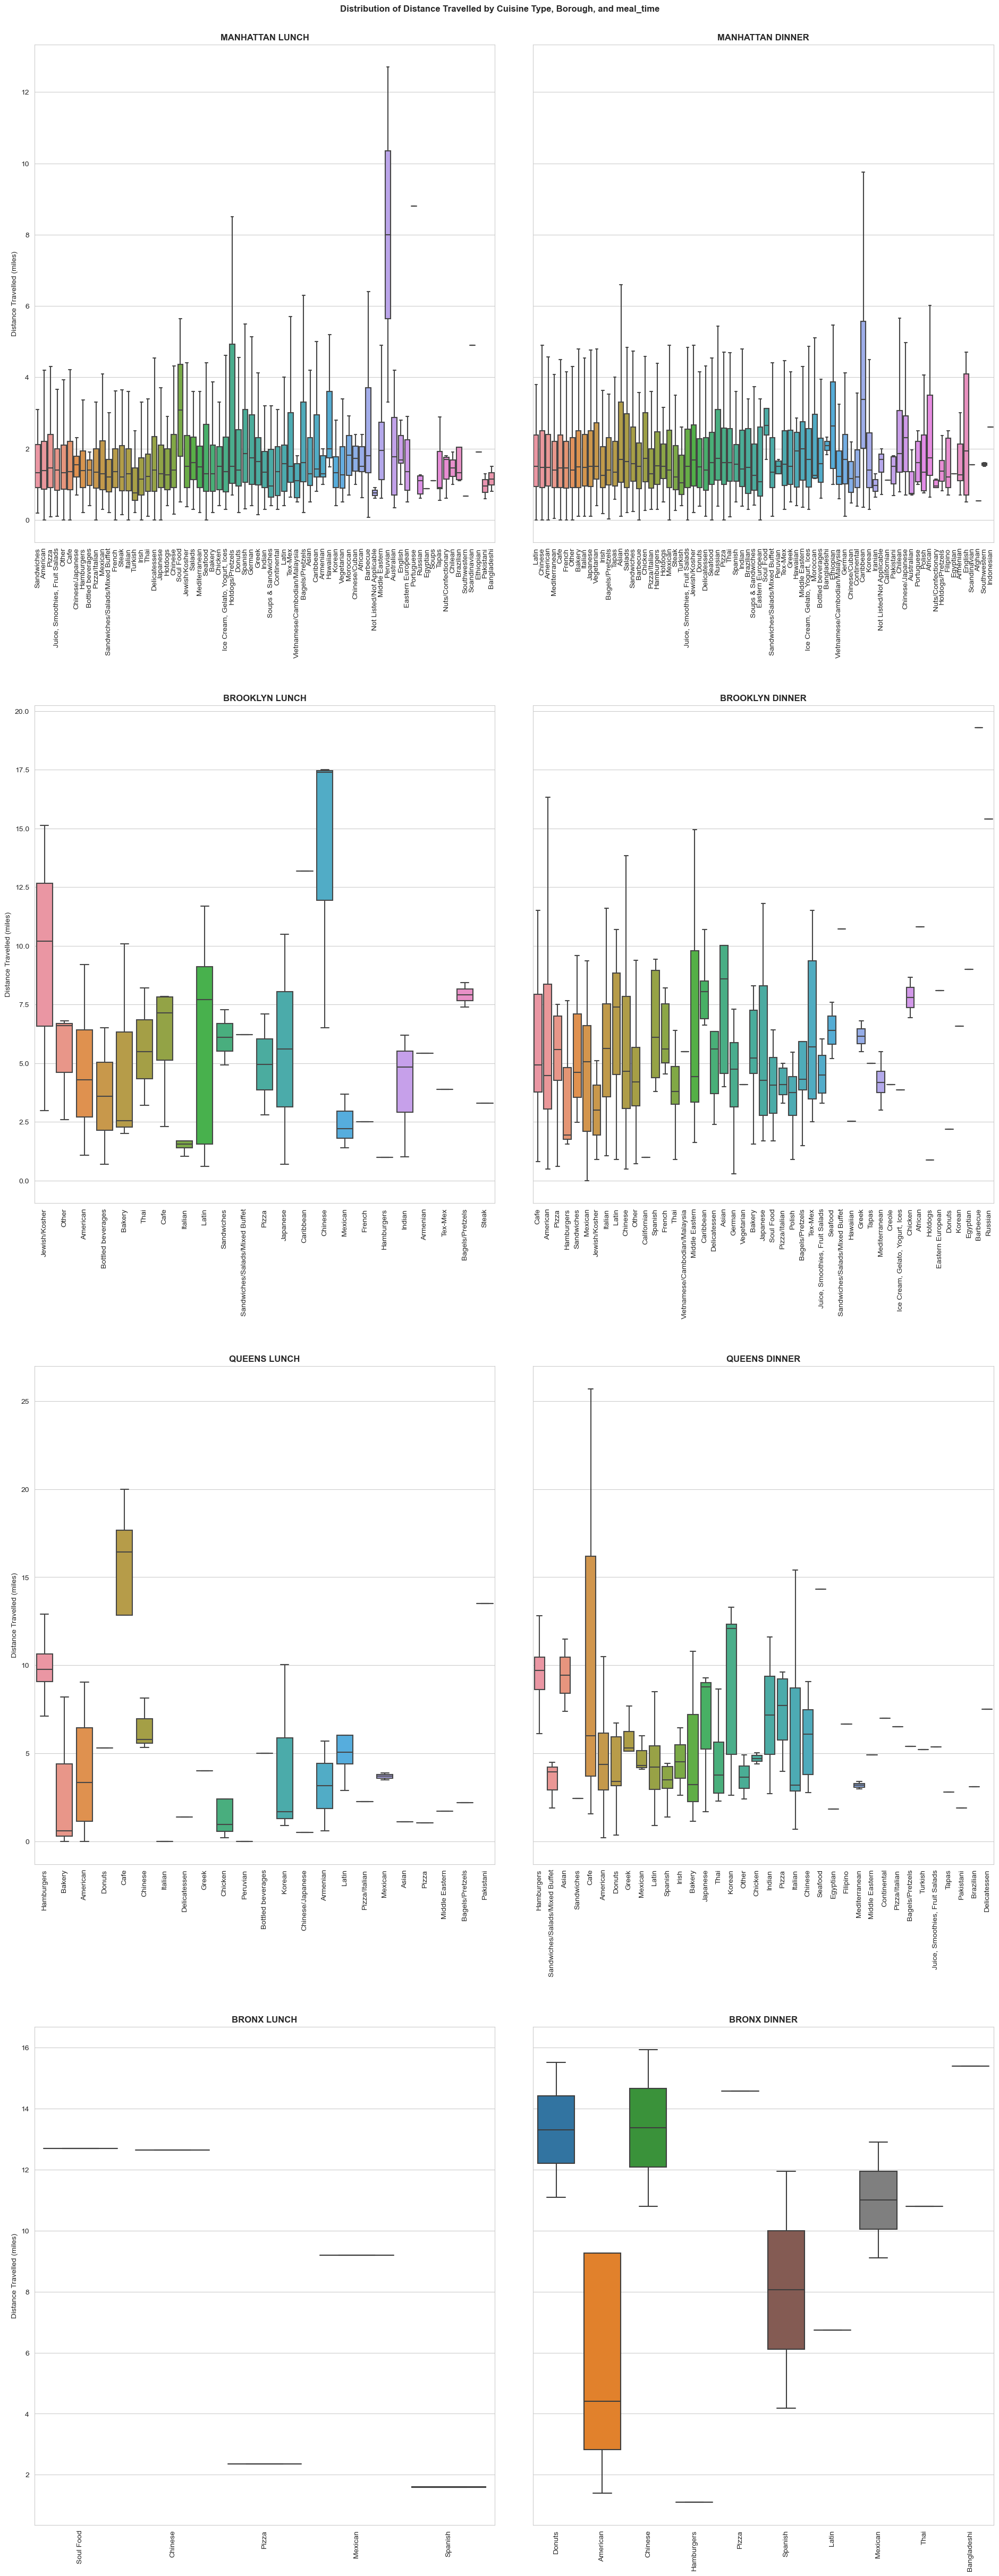

In [31]:
no_of_boro = len(matched_df['BORO'].unique())
meals = len(matched_df["meal_time"].unique())

sns.set_style("whitegrid")
fig, axs = plt.subplots(no_of_boro, meals, figsize=(20, 50), sharey='row')
for i, boro in enumerate(matched_df['BORO'].unique()):
    boro_data = matched_df[matched_df['BORO'] == boro]
    sns.boxplot(x='CUISINE DESCRIPTION', y='trip_distance', data=boro_data[boro_data['meal_time'] == 'lunch'], ax=axs[i, 0],showfliers = False)
    axs[i, 0].set_title(f'{boro} LUNCH', fontweight='bold')
    axs[i, 0].set_xticklabels(axs[i, 0].get_xticklabels(), rotation=90)
    axs[i, 0].set_xlabel('')
    axs[i, 0].set_ylabel('Distance Travelled (miles)')
    sns.boxplot(x='CUISINE DESCRIPTION', y='trip_distance', data=boro_data[boro_data['meal_time'] == 'dinner'], ax=axs[i, 1],showfliers = False)
    axs[i, 1].set_title(f'{boro} DINNER' , fontweight='bold')
    axs[i, 1].set_xticklabels(axs[i, 1].get_xticklabels(), rotation=90)
    axs[i, 1].set_xlabel('')
    axs[i, 1].set_ylabel('')


plt.suptitle('Distribution of Distance Travelled by Cuisine Type, Borough, and meal_time',fontweight='bold')
plt.tight_layout(pad=5.0)
plt.show()

Manhattan  
>General trend is similar for lunch and dinner time. Except for a few cuisines were people have traveled more than the rest.


Brooklyn  
>It can be observed by the number of cuisines plotted that more people visit Brooklyn for dinner than lunch.
 

Queens   
>People dining in Queens, on average, travel more during dinner than lunch.


Bronx
>The sparsity of the data indicates that people prefer dinner in the Bronx to lunch.

#### b) Understanding relation among Average Tip, Cuisine, Borough, Meal Time and Number of Passengers

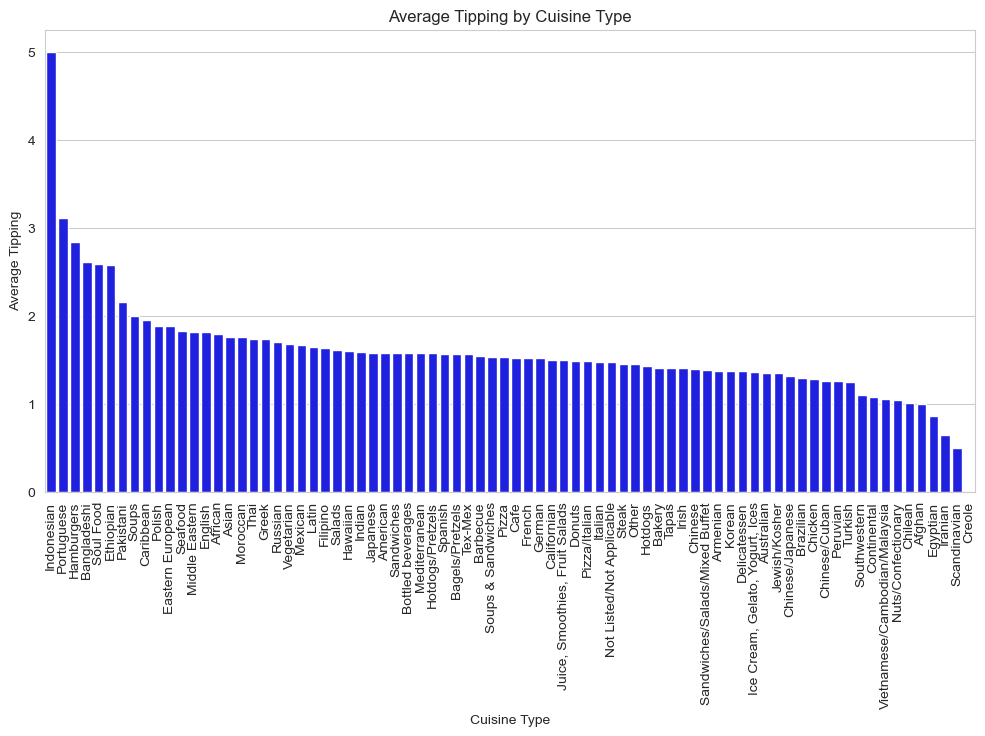

In [32]:
tip_by_cuisine = matched_df.groupby('CUISINE DESCRIPTION')['tip_amount'].mean().reset_index()

tip_by_cuisine = tip_by_cuisine.sort_values('tip_amount', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='CUISINE DESCRIPTION', y='tip_amount', data=tip_by_cuisine, color='b')
plt.xticks(rotation=90)
plt.xlabel('Cuisine Type')
plt.ylabel('Average Tipping')
plt.title('Average Tipping by Cuisine Type')
plt.show()

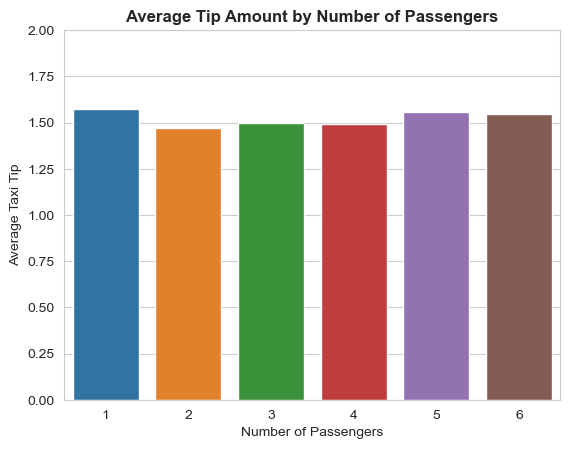

In [33]:
# Create a bar chart of the average tip amount for different number of passengers in the taxi

y = matched_df['tip_amount']
sns.barplot(x='passenger_count', y='tip_amount', data=matched_df, errorbar=None)

plt.title('Average Tip Amount by Number of Passengers', fontweight='bold')
plt.xlabel('Number of Passengers')
plt.ylabel('Average Taxi Tip')

plt.ylim(0, 2)

plt.show()


We can notice that average tipping per person is almost same

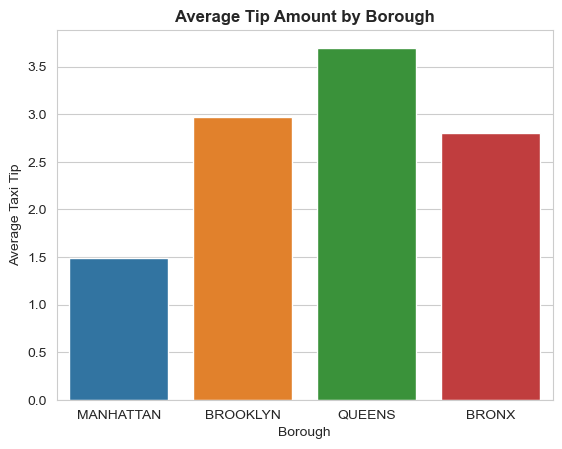

In [34]:
# Create a bar chart of the average tip amount for different number of passengers in the taxi
sns.barplot(x='BORO', y='tip_amount', data=matched_df, errorbar=None)

plt.title('Average Tip Amount by Borough', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Average Taxi Tip')

plt.show()


People who go to restaurants in Manhattan tip comparatively lower than another borough

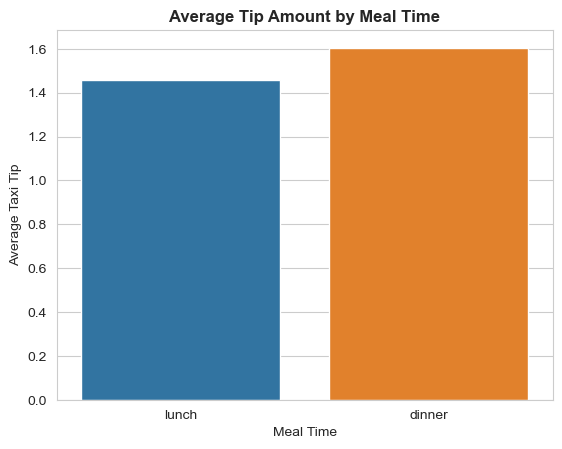

In [35]:
order = ['lunch', 'dinner']
sns.barplot(x='meal_time', y='tip_amount', data=matched_df, order=order, errorbar=None)

plt.title('Average Tip Amount by Meal Time', fontweight='bold')
plt.xlabel('Meal Time')
plt.ylabel('Average Taxi Tip')

plt.show()

Average taxi tip for lunch and dinner is almost same

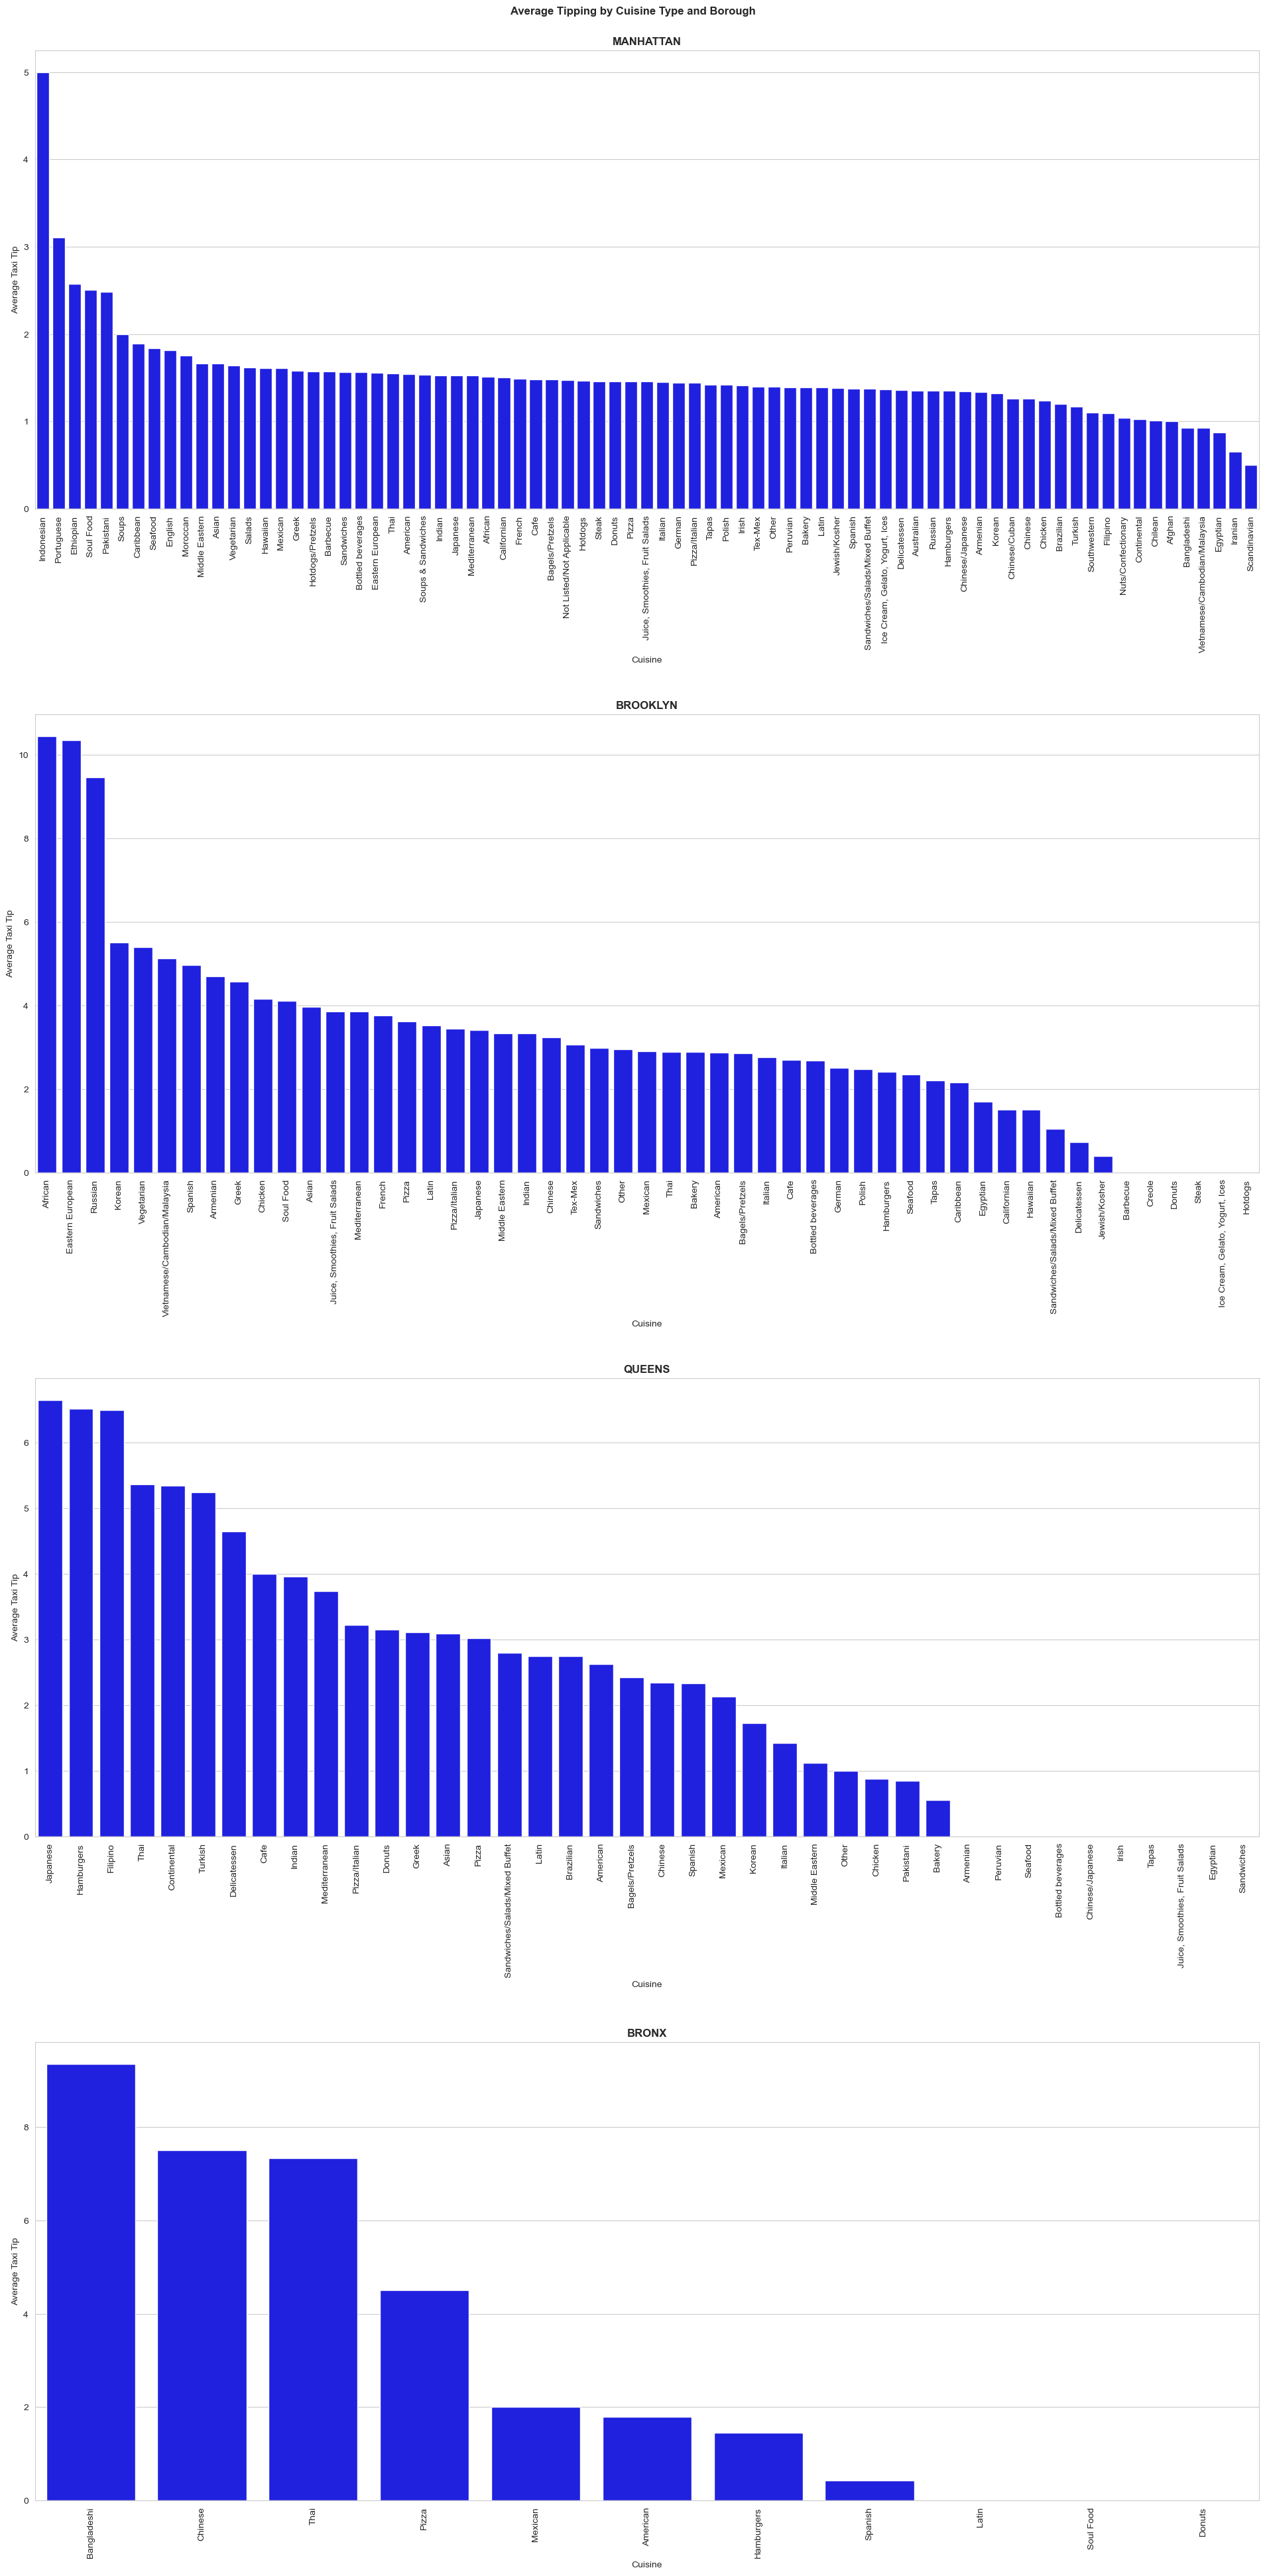

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

borough_order = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX']

# Calculate the mean tip amount by cuisine and borough
tip_by_cuisine_boro = matched_df.groupby(['CUISINE DESCRIPTION', 'BORO'])['tip_amount'].mean().reset_index()

# Sort the cuisines in descending order of average tipping
tip_by_cuisine_boro = tip_by_cuisine_boro.sort_values('tip_amount', ascending=False)

# Sort the data frame by borough in the desired order
tip_by_cuisine_boro = tip_by_cuisine_boro.set_index('BORO').loc[borough_order].reset_index()

fig, axs = plt.subplots(nrows=len(borough_order), ncols=1, figsize=(20, 40), sharey=False, sharex=False)

for i, boro in enumerate(borough_order):
    boro_data = tip_by_cuisine_boro[tip_by_cuisine_boro['BORO'] == boro]
    sns.barplot(x='CUISINE DESCRIPTION', y='tip_amount', data=boro_data, color='b', ax=axs[i])
    axs[i].set_title(boro, fontweight="bold")
    axs[i].set_xlabel('Cuisine')
    axs[i].set_ylabel('Average Taxi Tip')
    axs[i].tick_params(axis='x', labelrotation=90)

fig.suptitle('Average Tipping by Cuisine Type and Borough', fontweight="bold")
plt.tight_layout(pad=4)
plt.show()


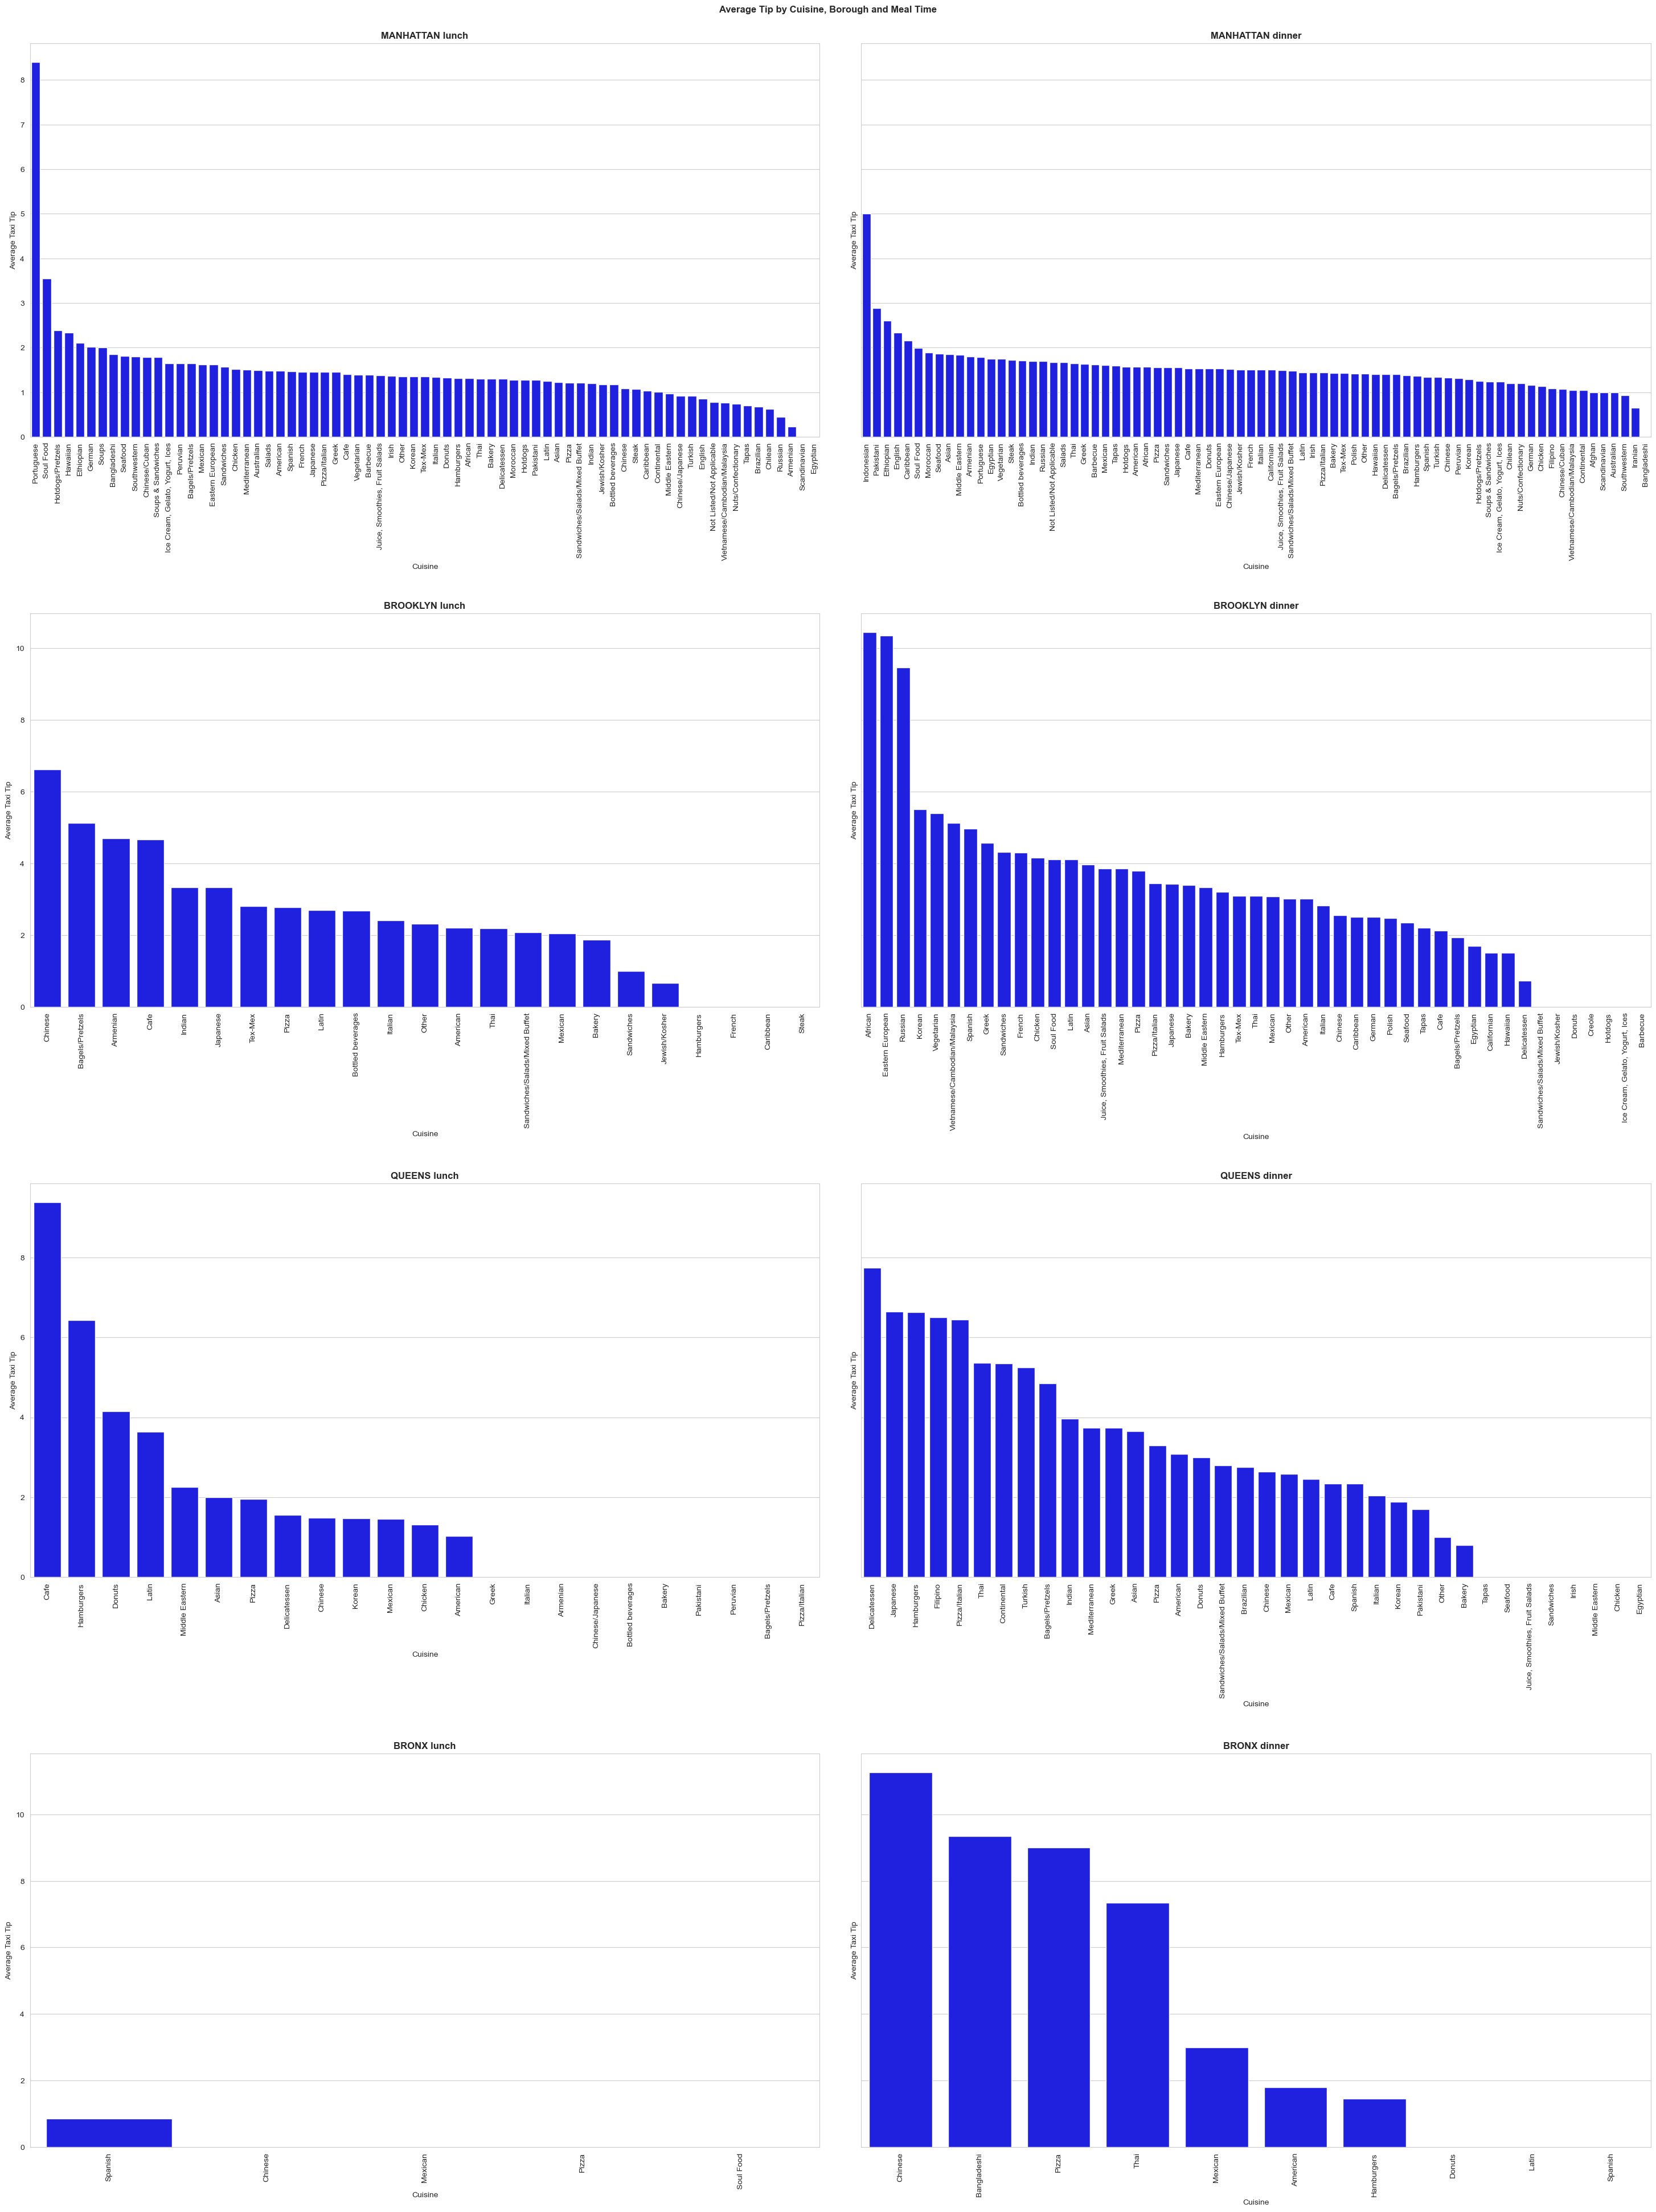

In [37]:
# Compute the average tip for each cuisine type, borough and meal time

avg_tip_by_cuisine_boro_meal = matched_df.groupby(['CUISINE DESCRIPTION', 'BORO', 'meal_time'])['tip_amount'].mean().reset_index()

fig, axs = plt.subplots(no_of_boro, 2, figsize=(30, 40), sharey="row")

for i, boro in enumerate(matched_df['BORO'].unique()):
    for j, meal in enumerate(['lunch', 'dinner']):
        data = avg_tip_by_cuisine_boro_meal[(avg_tip_by_cuisine_boro_meal['BORO'] == boro) & (avg_tip_by_cuisine_boro_meal['meal_time'] == meal)]
        data = data.sort_values('tip_amount', ascending=False)

        sns.barplot(x='CUISINE DESCRIPTION', y='tip_amount', data=data, ax=axs[i, j], color='b')
        axs[i, j].set_xticklabels(data['CUISINE DESCRIPTION'], rotation=90)
        axs[i, j].set_xlabel('Cuisine')
        axs[i, j].set_ylabel('Average Taxi Tip')
        axs[i, j].set_title(f'{boro} {meal}', fontweight='bold')

plt.suptitle('Average Tip by Cuisine, Borough and Meal Time', fontweight='bold')
plt.tight_layout(pad=4)
plt.show()


Manhattan  
>People tip the taxi drivers more during lunch time than at dinner.


Brooklyn  
>The exact opposite trend of Manhattan can be noticed, people tend to tip more during dinner.
 

Queens   
>Although the tip amount is higher during lunch, it's only valid for people dining at 1-2 cuisines, while during dinner, people are frequent to other cuisines and tip more.


Bronx
>The previous visualization shows that people visit Brox more often during dinner. Thus, tips are higher during dinner.

## Model Setup / Data

- Data:   
  - More information regarding the restaurant's rating and the average bill amount based on various party sizes, events scheduled, customer reviews.
<br><br>
- Model:

  - Collaborative-Based Recommendation Model: We can use this to recommend other restaurants to the people based on features like average dish price at the restaurant, cuisine, customer reviews, distance they travel, and so on. **RecBole** library has great models that we can potentially utilize to tackle this challenge <br> <br>
  ![Collaborative](img/colab_filter.jpg)



